In [1]:
import numpy as np
import pennylane as qml

from vqe_utils import *

# Variational Quantum Eigensolver (VQE)

In these examples the number of qubits $n$ will be 2 or 3.

In [2]:
# example data
with open("100-2.in") as f:
    in2 = f.read()
# read function provided by QHack
H = parse_hamiltonian_input(in2)

In [3]:
num_qubits = len(H.wires)
print(num_qubits)

2


The computational basis is $|\phi_0>=|00>$, $|\phi_1>=10>$, etc. This gives us $N=2^n$ computational basis states.

Any other states of interest will be linear combinations (superpositions) of these basis states:
$$ |\psi> = \sum_i^N c_{i} |\phi_i> $$
where $c_{i}$ are complex numbers (with the restriction $\sum_i c_i^* c_i = 1$).

$H$ is a matrix $N\times N$ that can describes the interactions between the states of the computational basis. $H$ can be decomposed into products of the Pauli operators (e.g. $X_0X_1$, $X_0Z_2$, $Z_0Y_1X_2$, etc) and the expectation of these operators can be calculated on quantum computers.

In [4]:
print(in2)

+ 32.7658547225 I S - 2.1433035249352805 X1 S - 2.1433035249352805 Z0 X1 S + 17.015854722500002 Z1 S + 3.913118960624632 X0 Z1 S - 23.359145277499998 Z0 Z1 S - 3.913118960624632 X0 S - 26.859145277499998 Z0


The eigenstates of $H$ are $|\Psi_0>$, ...
where $H|\Psi_i>=E_i|\Psi_i>$, with $E_i$ the energies of the system.

Eigenstates can be expressed as linear combinations of basis states.
$$ |\psi_j> = \sum_i^N c_{ij} |\phi_i> $$

Equivalently, a basis state can be transformed (rotated) into an arbitrary state by a unitary transformation $U(\theta)$. $$|\psi(\theta)> := U(\theta)|\phi_0>$$
$\theta$ is an alternate set of parameters ($c_{ij}=c_{ij}(\theta)$)

We can find the ground-state $|\psi_0>$  by finding $\theta=\theta_0$ such that $|\psi(\theta_0)>=|\psi_0>$.

This means minimizing $E(\theta)=<\phi_0|U^\dagger(\theta)HU(\theta)|\phi_0>$, so we can treat $E(\theta)$ as the cost of an optimization problem.

The ground state energy is the "optimal value"
$$E_0 = \min_\theta <\phi_0|U^\dagger(\theta)HU(\theta)|\phi_0>$$

## VQE-100: Given $H$ and $U(\theta)$ find $\theta_{gs}$ corresponding to the ground state of $H$

Here we are given an ansatz. Given the normalization condition of $c$ our circuit only need $2^n-1$ complex parameters. The given ansatz has $(2^n-1)\times3$ real angles which should be enough.

In [5]:
num_param_sets = (2 ** num_qubits) - 1
params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_param_sets, 3))

In [6]:
def variational_ansatz(params, wires):
    """
    DO NOT MODIFY anything in this function! It is used to judge your solution.

    This is ansatz is used to help with the problem structure. It applies
    alternating layers of rotations and CNOTs.

    Don't worry about the contents of this function for now—you'll be designing
    your own ansatze in a later problem.

    Args:
        params (np.ndarray): An array of floating-point numbers with size (n, 3),
            where n is the number of parameter sets required (this is determined by
            the problem Hamiltonian).
        wires (qml.Wires): The device wires this circuit will run on.
    """
    n_qubits = len(wires)
    n_rotations = len(params)

    if n_rotations > 1:
        n_layers = n_rotations // n_qubits
        n_extra_rots = n_rotations - n_layers * n_qubits

        # Alternating layers of unitary rotations on every qubit followed by a
        # ring cascade of CNOTs.
        for layer_idx in range(n_layers):
            layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, :]
            qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
            qml.broadcast(qml.CNOT, wires, pattern="ring")

        # There may be "extra" parameter sets required for which it's not necessarily
        # to perform another full alternating cycle. Apply these to the qubits as needed.
        extra_params = params[-n_extra_rots:, :]
        extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
        qml.broadcast(qml.Rot, extra_wires, pattern="single", parameters=extra_params)
    else:
        # For 1-qubit case, just a single rotation to the qubit
        qml.Rot(*params[0], wires=wires[0])

To execute the circuit we need a `quantum device`

In [7]:
dev = qml.device("qiskit.aer", wires=num_qubits)

Define the cost function with `ExpvalCost`

In [8]:
cost = qml.ExpvalCost(variational_ansatz, H, dev)

Initial energy:

In [9]:
print(cost(params))

3.6836874401252295


What the circuit looks like:

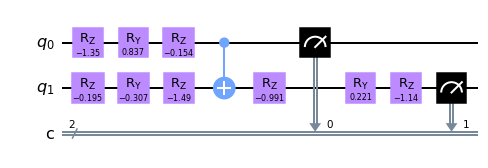

In [10]:
@qml.qnode(dev)
def circuit(params):
    variational_ansatz(params,dev.wires)
    return qml.expval(qml.Identity(0))
result = circuit(params)
dev._circuit.draw('mpl')

Combine into a function and iterate `opt.step(cost)` to update parameters

In [11]:
def run_vqe(H):
    """Runs the variational quantum eigensolver on the problem Hamiltonian using the
    variational ansatz specified above.

    Fill in the missing parts between the # QHACK # markers below to run the VQE.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The ground state energy of the Hamiltonian.
    """
    # Initialize parameters
    num_qubits = len(H.wires)
    num_param_sets = (2 ** num_qubits) - 1
    params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_param_sets, 3))

    energy = 0

    # QHACK #

    # Create a quantum device, set up a cost funtion and optimizer, and run the VQE.
    # (We recommend ~500 iterations to ensure convergence for this problem,
    # or you can design your own convergence criteria)
    dev = qml.device("default.qubit", wires=num_qubits)

    cost = qml.ExpvalCost(variational_ansatz, H, dev)

    opt = qml.GradientDescentOptimizer(0.1)
    #opt = qml.AdamOptimizer()
    
    max_iter = 200
    
    for i in range(max_iter):
        if i % 20 == 0: print(f"step {i}, cost {cost(params)}")
        params = opt.step(cost, params)

    energy = cost(params)

    # QHACK #

    # Return the ground state energy
    return energy

In [12]:
with open("100-1.in") as f:
    in1 = f.read()
print(in1)

+ 5.906709445000001 I S - 4.286607049870561 X0 S - 6.343290554999999 Z0


In [13]:
# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
ground_state_energy = run_vqe(H)
print(f"{ground_state_energy:.6f}")

step 0, cost 7.325390385290028
step 20, cost -1.7487418165812745
step 40, cost -1.7491598691811805
step 60, cost -1.7491598763214076
step 80, cost -1.7491598763215297
step 100, cost -1.7491598763215288
step 120, cost -1.7491598763215288
step 140, cost -1.7491598763215284
step 160, cost -1.7491598763215284
step 180, cost -1.7491598763215284
-1.749160


In [14]:
with open("100-1.ans") as f:
    ans1 = f.read()
print(ans1)

-1.749160



In [15]:
with open("100-2.in") as f:
    in2 = f.read()
print(in2)

+ 32.7658547225 I S - 2.1433035249352805 X1 S - 2.1433035249352805 Z0 X1 S + 17.015854722500002 Z1 S + 3.913118960624632 X0 Z1 S - 23.359145277499998 Z0 Z1 S - 3.913118960624632 X0 S - 26.859145277499998 Z0


In [16]:
# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
ground_state_energy = run_vqe(H)
print(f"{ground_state_energy:.6f}")

step 0, cost 14.134260693073779
step 20, cost -1.918396962176736
step 40, cost -1.9905800852771627
step 60, cost -2.0100585487365272
step 80, cost -2.0256131631290692
step 100, cost -2.0356151994444716
step 120, cost -2.040935391927089
step 140, cost -2.04349760351608
step 160, cost -2.0446827422699485
step 180, cost -2.045222990325488
-2.045468


In [17]:
with open("100-2.ans") as f:
    ans1 = f.read()
print(ans1)

-2.045671


## VQE-200: Designing an ansatz $U(\theta)$

Suppose we know that the eigenstate must have a particular form.

We might want to map the quantum states of our basis to a one-hot encoding.

$$ \left\vert \psi(\alpha) \right\rangle = \alpha_0 \left\vert 100\cdots0 \right\rangle + \alpha_1 \left\vert 010\cdots0 \right\rangle + \cdots + \alpha_{n-2} \left\vert 0\cdots010 \right\rangle + \alpha_{n-1} \left\vert 0\cdots001 \right\rangle $$

where $\alpha_i$ are *real* numbers.

The strategy for this circuit is to iteratively apply Xs and RYs. The X flips one qubit from |0> into state |1> or vice-versa. The RY is a real number because Y is entirely imaginary ($RY(\theta)=e^{i\theta Y}$).

This means we only need $2^n-1$ angles!

Below we'll use $c$ and $s$ as shorthand for $\cos$ and $\sin$.

Base case:

$X_0|00> = |10>$

$RY(\theta)_1|10> = c(\theta)|10> + s(\theta)|11>$

Then entangle (using the CNOT (also known as CX) to swap $q_0$ back to 0:

$CNOT(0,1)(c(\theta)|10> + s(\theta)|11>) = c(\theta)|10> + s(\theta)|01>$

For more qubits we use controlled rotations (CRY) to rotate the $i$th qubit on the term with 1 in $i-1$ qubit and then use a CNOT on the opposite wires to unflip the $i-1$th qubit.

Iterate:
<code>
for i in range(2,num_qubits):
    CRY(i-1,1)
    CNOT(i,i-1)
</code>


Example:

$CRY(\theta',1,2)[c(\theta)|100> + s(\theta)|010>] = c(\theta)|100> + s(\theta)[ c(\theta') |010> + s(\theta') |011> ]$

$CNOT(2,1)[c(\theta)|100> + s(\theta)[ c(\theta') |010> + s(\theta') |011> ] = c(\theta)|100> + s(\theta)c(\theta') |010> + s(\theta)s(\theta') |001>$

In [18]:
def variational_ansatz(params, wires):
    """The variational ansatz circuit.

    Fill in the details of your ansatz between the # QHACK # comment markers. Your
    ansatz should produce an n-qubit state of the form

        a_0 |10...0> + a_1 |01..0> + ... + a_{n-2} |00...10> + a_{n-1} |00...01>

    where {a_i} are real-valued coefficients.

    Args:
         params (np.array): The variational parameters.
         wires (qml.Wires): The device wires that this circuit will run on.
    """

    # QHACK #
    n_qubits = len(wires)
    qml.PauliX(wires=0)
    qml.RY(params[0], wires=1)
    qml.CNOT(wires=[1,0])

    if n_qubits > 2:
        for i in range(2,n_qubits):
            qml.CRY(params[i-1], wires=[i-1,i])
            qml.CNOT(wires=[i,i-1])
    # QHACK #

+ 15.531709 I S + 0.218291 Z0 S - 6.125 Z1 S - 2.143304 X0 X1 S - 2.143304 Y0 Y1 S - 9.625 Z2 S - 3.913119 X1 X2 S - 3.913119 Y1 Y2


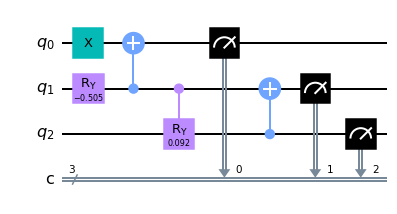

In [19]:
###############
with open("200-2.in") as f:
    in2 = f.read()
print(in2)
# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)
# Initialize the quantum device
num_qubits = len(H.wires)
dev = qml.device("qiskit.aer", wires=num_qubits)
###############

# Randomly choose initial parameters (how many do you need?)
params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_qubits-1))
@qml.qnode(dev)
def circuit(params):
    variational_ansatz(params,dev.wires)
    return qml.expval(qml.Identity(0))
result = circuit(params)
dev._circuit.draw('mpl')

In [20]:
def run_vqe(H):
    """Runs the variational quantum eigensolver on the problem Hamiltonian using the
    variational ansatz specified above.

    Fill in the missing parts between the # QHACK # markers below to run the VQE.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The ground state energy of the Hamiltonian.
    """
    energy = 0

    # QHACK #

    # Initialize the quantum device
    num_qubits = len(H.wires)
    dev = qml.device("default.qubit", wires=num_qubits)

    # Randomly choose initial parameters (how many do you need?)
    params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_qubits-1))

    # Set up a cost function
    cost = qml.ExpvalCost(variational_ansatz, H, dev)

    # Set up an optimizer
    opt = qml.GradientDescentOptimizer(0.1)

    max_iter = 400
    # Run the VQE by iterating over many steps of the optimizer
    for i in range(max_iter):
        if i % 50 == 0: print(f"step {i}, cost {cost(params)}")
        params = opt.step(cost, params)

    energy = cost(params)

    # QHACK #

    # Return the ground state energy
    return energy

In [21]:
with open("200-1.in") as f:
    in1 = f.read()
print(in1)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
ground_state_energy = run_vqe(H)
print(f"{ground_state_energy:.6f}")

with open("200-1.ans") as f:
    ans1 = f.read()
print(f"Answer: {ans1}")

+ 5.906709 I S + 0.218291 Z0 S - 6.125 Z1 S - 2.143304 X0 X1 S - 2.143304 Y0 Y1
step 0, cost 10.135724468934095
step 50, cost -1.7491612220155868
step 100, cost -1.7491612220155868
step 150, cost -1.7491612220155868
step 200, cost -1.7491612220155868
step 250, cost -1.7491612220155868
step 300, cost -1.7491612220155868
step 350, cost -1.7491612220155868
-1.749161
Answer: -1.749160



In [22]:
with open("200-2.in") as f:
    in2 = f.read()
print(in2)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
ground_state_energy = run_vqe(H)
print(f"{ground_state_energy:.6f}")

with open("200-2.ans") as f:
    ans2 = f.read()
print(f"Answer: {ans2}")

+ 15.531709 I S + 0.218291 Z0 S - 6.125 Z1 S - 2.143304 X0 X1 S - 2.143304 Y0 Y1 S - 9.625 Z2 S - 3.913119 X1 X2 S - 3.913119 Y1 Y2
step 0, cost 3.4910248756324034
step 50, cost -2.045671405958355
step 100, cost -2.045672287677073
step 150, cost -2.0456722876770908
step 200, cost -2.0456722876770885
step 250, cost -2.0456722876770908
step 300, cost -2.0456722876770908
step 350, cost -2.0456722876770908
-2.045672
Answer: -2.045671


## VQE-500: Find the excited states of $H$

VQE as described in the above seems very limited compared to classical diagonalization. We also want the excited states in order to fully describe real systems (e.g. molecules, nuclei).

### Attempt #1: Variational Quantum Deflation

One strategy is to iterate VQE but modify the cost function to force the lowest state to be orthogonal to all the previously found states.

In [23]:
# Steal ansatz from VQE-100 (actually changing Rot to RY increases speed (but risks not being flexible enough))
def U(params,wires):
    n_qubits = len(wires)
    n_rotations = len(params)

    if n_rotations > 1:
        n_layers = n_rotations // n_qubits
        n_extra_rots = n_rotations - n_layers * n_qubits

        # Alternating layers of unitary rotations on every qubit followed by a
        # ring cascade of CNOTs.
        for layer_idx in range(n_layers):
            layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, :]
            qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
            qml.broadcast(qml.CNOT, wires, pattern="ring")

        # There may be "extra" parameter sets required for which it's not necessarily
        # to perform another full alternating cycle. Apply these to the qubits as needed.
        extra_params = params[-n_extra_rots:, :]
        extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
        qml.broadcast(qml.Rot, extra_wires, pattern="single", parameters=extra_params)
    else:
        # For 1-qubit case, just a single rotation to the qubit
        qml.Rot(*params[0], wires=wires[0])

In order to do this we need to calculate the overlap between states created by different transformations .i.e. $<\psi(\theta)|\psi(\theta')>=<\phi_0|U^\dagger(\theta)U(\theta')|\phi_0>$. One way to do this is to get the state (only available with a classical simulator), and construct the density matrix $|\psi(\theta)><\psi(\theta)|$ which we can add as a term to the Hamiltonian.

In [24]:
###############
# example data
with open("200-2.in") as f:
    in2 = f.read()
#print(in2)
# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)
# Initialize the quantum device
num_qubits = len(H.wires)
dev = qml.device("default.qubit", wires=num_qubits)
# Randomly choose initial parameters
params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_qubits-1,3))
###############

# needed to use qml.state
qml.enable_tape()

# get_state function
@qml.qnode(dev)
def get_state(params):
    U(params, dev.wires)
    return qml.state()

# construct overlap Hamiltonian
state = get_state(params)
dens_matrix = np.outer(state.conj(), state)
overlap_Ham = qml.Hamiltonian(coeffs=[1.,], observables=[qml.Hermitian(dens_matrix, dev.wires),])

# Set up a cost function
cost = qml.ExpvalCost(variational_ansatz, H + overlap_Ham, dev)

In [25]:
def find_excited_states_vqd(H):
    """
    Fill in the missing parts between the # QHACK # markers below. Implement
    a variational method that can find the three lowest energies of the provided
    Hamiltonian.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The lowest three eigenenergies of the Hamiltonian as a comma-separated string,
        sorted from smallest to largest.
    """

    energies = np.zeros(3)

    # QHACK #
    num_qubits = len(H.wires)
    #print(H.wires)
    num_param_sets = (2 ** num_qubits) - 1
    saved_params = []

    dev = qml.device("default.qubit", wires=num_qubits)

    # circuit from vqe-100
    def variational_ansatz(params, wires):\
        #'''
        n_qubits = len(wires)
        n_rotations = len(params)

        if n_rotations > 1:
            n_layers = n_rotations // n_qubits
            n_extra_rots = n_rotations - n_layers * n_qubits

            # Alternating layers of unitary rotations on every qubit followed by a
            # ring cascade of CNOTs.
            for layer_idx in range(n_layers):
                layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits]
                if layer_idx == 0:
                  qml.broadcast(qml.RY, wires, pattern="single", parameters=layer_params)
                else:
                  qml.broadcast(qml.CNOT, wires, pattern="ring")
                  qml.broadcast(qml.RY, wires, pattern="single", parameters=layer_params)

            # There may be "extra" parameter sets required for which it's not necessarily
            # to perform another full alternating cycle. Apply these to the qubits as needed.
            extra_params = params[-n_extra_rots:]
            extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
            extra_wires2 = wires[: n_qubits - 2 - n_extra_rots : -1]
            #print("ew",extra_wires)
            #print("test",extra_wires2)
            if n_qubits > 2:
                qml.broadcast(qml.CNOT, extra_wires2, pattern="ring")
            else:
                qml.broadcast(qml.CNOT, [1,0], pattern='chain')
            qml.broadcast(qml.RY, extra_wires, pattern="single", parameters=extra_params)
        else:
            # For 1-qubit case, just a single rotation to the qubit
            qml.RY(params[0], wires=wires[0])
            n_qubits = len(wires)
            #'''
            '''
        n_rotations = len(params)

        if n_rotations > 1:
            n_layers = n_rotations // n_qubits
            n_extra_rots = n_rotations - n_layers * n_qubits

            # Alternating layers of unitary rotations on every qubit followed by a
            # ring cascade of CNOTs.
            for layer_idx in range(n_layers):
                layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, :]
                qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
                qml.broadcast(qml.CNOT, wires, pattern="ring")

            # There may be "extra" parameter sets required for which it's not necessarily
            # to perform another full alternating cycle. Apply these to the qubits as needed.
            extra_params = params[-n_extra_rots:, :]
            extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
            qml.broadcast(qml.Rot, extra_wires, pattern="single", parameters=extra_params)
        else:
            # For 1-qubit case, just a single rotation to the qubit
            qml.Rot(*params[0], wires=wires[0])
            '''

    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets))
    #params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets,3))


    # find ground state
    cost0 = qml.ExpvalCost(variational_ansatz, H, dev)

    #opt = qml.GradientDescentOptimizer(0.1)
    opt = qml.AdamOptimizer(0.1)
    #opt = qml.AdagradOptimizer(0.1)

    #print(H.wires)

    min_50 = np.inf
    for i in range(500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            min_50 = cost0(params)
            print(f"step {i}, E_0 {cost0(params)}")
        params = opt.step(cost0, params)

    energies[0] = cost0(params)
    saved_params.append(params)
    #print(energies[0],cost0(params))

    # function for overlaps
    qml.enable_tape()

    @qml.qnode(dev)
    def get_state(params):
        variational_ansatz(params, dev.wires)
        return qml.state()
     
    overlap_state1 = get_state(params)
    overlap_herm1 = np.outer(overlap_state1.conj(), overlap_state1)
    #print("psi_0",overlap_state1)
    #print(overlap_herm1)

    # find the first excited
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets))
    #params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets,3))
    a = 100 # big number to enforce orthogonality
    overlap_Ham = qml.Hamiltonian(coeffs=[a,], observables=[qml.Hermitian(overlap_herm1,dev.wires),])
    #print("a|psi_0><psi_0",overlap_Ham,overlap_Ham.ops)
    H1 = H + overlap_Ham
    #print("H1",H1)
    cost = qml.ExpvalCost(variational_ansatz, H1, dev)# + qml.ExpvalCost(variational_ansatz, overlap_Ham, dev)
    #print(cost(saved_params[0]),a+energies[0],a+cost0(saved_params[0]))

    min_50 = np.inf
    for i in range(1500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            print(f"step {i}, E_1 {cost0(params)}, cost {cost(params)}")
            min_50 = cost0(params)
        params = opt.step(cost, params)  

    energies[1] = cost0(params)
    saved_params.append(params)
    #print(energies[1],cost(params))

    overlap_state2 = get_state(params)
    overlap_herm2 = np.outer(overlap_state2.conj(), overlap_state2)
    #print("|psi_1>",overlap_state2)
    #print(overlap_herm2)

    # find the second excited    
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets))
    #params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets,3))
    b = 100
    overlap_Ham = qml.Hamiltonian(coeffs=[a,b], observables=[qml.Hermitian(overlap_herm1,dev.wires),qml.Hermitian(overlap_herm2,dev.wires)])
    #print("a|psi_0><psi_0|+b|psi_1><psi_1",overlap_Ham,overlap_Ham.ops)
    H2 = H + overlap_Ham
    #print("H2",H2)
    cost = qml.ExpvalCost(variational_ansatz, H2, dev)# + qml.ExpvalCost(variational_ansatz, overlap_Ham, dev)

    min_50 = np.inf
    for i in range(1500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            print(f"step {i}, E_2 {cost0(params)}, cost {cost(params)}")
            min_50 = cost0(params)
        params = opt.step(cost, params)  

    energies[2] = cost0(params)
    saved_params.append(params)

    # QHACK #

    return ",".join([str(E) for E in energies])

In [26]:
with open("500-1.in") as f:
    in1 = f.read()
print(in1)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states_vqd(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-1.ans") as f:
    ans1 = f.read()
print(f"Answer: {ans1}")

+ 0.35807927646889326 X0 S + 0.7556205249987815 X1 S + 0.04828309125493235 X2 S + 0.07927207111541623 Z1 Z2

step 0, E_0 0.4610031506378779
step 50, E_0 -1.1558669004429414
step 100, E_0 -1.1658532806705482
step 0, E_1 0.2814231653615292, cost 1.0762193050893971
step 50, E_1 -0.799812695037584, cost -0.7930265105404013
step 100, E_1 -1.0682420399024957, cost -1.0682362836262391
step 150, E_1 -1.0698443397402295, cost -1.0698438332729554
step 0, E_2 0.09199744829245758, cost 6.806062370319983
step 50, E_2 0.06095747211423726, cost 0.08174830662863554
step 100, E_2 -0.4460306194047179, cost -0.44592170018707883
step 150, E_2 -0.44970601693281625, cost -0.44970546694552627
Found energies: -1.1658815707909278,-1.0698449674900292,-0.4497233455394788
Answer: -1.1658819,-1.0698449,-0.44972335



In [27]:
with open("500-2.in") as f:
    in2 = f.read()
print(in2)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states_vqd(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-2.ans") as f:
    ans2 = f.read()
print(f"Answer: {ans2}")

+ 0.4977616234240615 X0 S + 0.5635396435844906 X1 S + 0.32588875859719557 Z1 Z2 S + 0.18913602999217294 X2
step 0, E_0 -0.053048852967444694
step 50, E_0 -1.3123272379524495
step 100, E_0 -1.3179188406917168
step 0, E_1 0.09438114733578348, cost 17.160489466676975
step 50, E_1 -0.1627694892381598, cost -0.15068843202125712
step 100, E_1 -0.9751672368592896, cost -0.9746014638776492
step 150, E_1 -0.9936800340585483, cost -0.9936791842775783
step 200, E_1 -0.9941293307849298, cost -0.9941293184790314
step 0, E_2 0.5690990223565109, cost 2.32581506562368
step 50, E_2 0.11123046837318869, cost 0.11535500686188581
step 100, E_2 -0.2702787654735078, cost -0.27026458418480875
step 150, E_2 -0.30867147413881335, cost -0.3086708197293798
step 200, E_2 -0.32013381693155213, cost -0.3201335896074901
step 250, E_2 -0.3222475462670268, cost -0.3222475315547641
step 300, E_2 -0.322431310699584, cost -0.32243122600422297
Found energies: -1.317959022495287,-0.9941300069017153,-0.3224360276776015
Answ

### Attempt #2: Weighted Subspace-search VQE

Because $U(\theta)$ is unitary and the initial states are orthogonal the states that $U$ transforms these to are also orthogonal (even if they are not the true eigenstates).

$|\psi_0> = U|\phi_0>$, $|\psi_1> = U|\phi_1>$

$$ <\psi_0 | \psi_1 > = <\phi_0| U^\dagger U |phi_1> = <\phi_0 | \phi_1> =0$$

This means we can simulataneously find eigenstates by finding a single $U(theta)$. We do this by simultaneously minimizing the expectation values of $U$ on multiple input states i.e. $<H_i>=<\phi_i|U^\dagger(\theta)HU(\theta)|\phi_i>$.

We get the bottom three in the correct order by weighting each expectation in order.

Cost: $\sum_{i=0}^3 w_i <H_i>$ with $w_0>w_1>w_2$

In [28]:
def find_excited_states_wss(H):
    """
    Fill in the missing parts between the # QHACK # markers below. Implement
    a variational method that can find the three lowest energies of the provided
    Hamiltonian.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The lowest three eigenenergies of the Hamiltonian as a comma-separated string,
        sorted from smallest to largest.
    """

    energies = np.zeros(3)

    # QHACK #
    num_qubits = len(H.wires)

    def phi0():
        qml.PauliX(0)

    def phi1():
        qml.PauliX(1)

    def phi2():
        qml.PauliX(2)

    def U(params,wires):
        n_qubits = len(wires)
        n_rotations = len(params)

        if n_rotations > 1:
            n_layers = n_rotations // n_qubits
            n_extra_rots = n_rotations - n_layers * n_qubits

            # Alternating layers of unitary rotations on every qubit followed by a
            # ring cascade of CNOTs.
            for layer_idx in range(n_layers):
                layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, :]
                qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
                qml.broadcast(qml.CNOT, wires, pattern="ring")

            # There may be "extra" parameter sets required for which it's not necessarily
            # to perform another full alternating cycle. Apply these to the qubits as needed.
            extra_params = params[-n_extra_rots:, :]
            extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
            qml.broadcast(qml.Rot, extra_wires, pattern="single", parameters=extra_params)
        else:
            # For 1-qubit case, just a single rotation to the qubit
            qml.Rot(*params[0], wires=wires[0])
        
    def ansatz0(params,wires):
        phi0()
        U(params,wires)
    def ansatz1(params,wires):
        phi1()
        U(params,wires)
    def ansatz2(params,wires):
        phi2()
        U(params,wires)

    num_param_sets = (2 ** num_qubits) - 1

    dev = qml.device("default.qubit",wires=num_qubits)

    def cost(params):
        E0 = qml.ExpvalCost(ansatz0, 3*H, dev).__call__(params)
        E1 = qml.ExpvalCost(ansatz1, 2*H, dev).__call__(params)
        E2 = qml.ExpvalCost(ansatz2, 1*H, dev).__call__(params)
        return E0 + E1 + E2

    #opt = qml.AdamOptimizer(0.1)
    #opt = qml.MomentumOptimizer()
    #opt = qml.GradientDescentOptimizer(0.1)
    #opt = qml.AdagradOptimizer(0.1)
    opt = qml.RMSPropOptimizer()

    num_runs = 1
    max_iter = 400
    best_tot = np.inf
    best_energies = np.zeros(3)
    for j in range(num_runs):
        current_energies = np.zeros(3)
        params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_param_sets,3))
        for i in range(max_iter):
            if i % 50 == 0: print(f"step {i}, cost {cost(params)}")
            params = opt.step(cost, params)

        current_energies[0] = qml.ExpvalCost(ansatz0,H,dev).__call__(params)
        current_energies[1] = qml.ExpvalCost(ansatz1,H,dev).__call__(params)
        current_energies[2] = qml.ExpvalCost(ansatz2,H,dev).__call__(params)
        #print(current_energies)
        # walrus := not allowed :(
        #if (E:=np.sum(current_energies))<best_tot:
        if np.sum(current_energies)<best_tot:
            #print(E)
            best_tot = np.sum(current_energies)
            best_energies = current_energies
    
    energies = np.sort(best_energies)
    
    # QHACK #

    return ",".join([str(E) for E in energies])

In [29]:
with open("500-1.in") as f:
    in1 = f.read()
print(in1)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states_wss(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-1.ans") as f:
    ans1 = f.read()
print(f"Answer: {ans1}")

+ 0.35807927646889326 X0 S + 0.7556205249987815 X1 S + 0.04828309125493235 X2 S + 0.07927207111541623 Z1 Z2

step 0, cost -1.3593886818489334
step 50, cost -3.97723212639673
step 100, cost -5.763588209050652
step 150, cost -6.025490666803086
step 200, cost -6.05736086242096
step 250, cost -6.061476482152766
step 300, cost -6.0614792357643275
step 350, cost -6.0614797294921
Found energies: -1.1617309971027663,-1.0652539841630233,-0.445778796091987
Answer: -1.1658819,-1.0698449,-0.44972335



In [30]:
with open("500-2.in") as f:
    in2 = f.read()
print(in2)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states_wss(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-2.ans") as f:
    ans2 = f.read()
print(f"Answer: {ans2}")

+ 0.4977616234240615 X0 S + 0.5635396435844906 X1 S + 0.32588875859719557 Z1 Z2 S + 0.18913602999217294 X2
step 0, cost -0.22863755783287068
step 50, cost -2.8090101021865506
step 100, cost -4.16478640192333
step 150, cost -4.565837904706925
step 200, cost -5.331570109318939
step 250, cost -5.669320163143319
step 300, cost -5.6945894412577065
step 350, cost -5.6977248721603395
Found energies: -1.3070531501167733,-0.7811288953654121,-0.2143246228661433
Answer: -1.31795925,-0.99412998,-0.32243601


# Alternate Ansatz

In [31]:
def find_excited_states_vqd(H):
    """
    Fill in the missing parts between the # QHACK # markers below. Implement
    a variational method that can find the three lowest energies of the provided
    Hamiltonian.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The lowest three eigenenergies of the Hamiltonian as a comma-separated string,
        sorted from smallest to largest.
    """

    energies = np.zeros(3)

    # QHACK #
    num_qubits = len(H.wires)
    #print(H.wires)
    num_param_sets = (2 ** num_qubits) - 1
    saved_params = []

    dev = qml.device("default.qubit", wires=num_qubits)

    # circuit from vqe-100
    def variational_ansatz(params, wires):
        n_qubits = len(wires)
        n_rotations = len(params)

        for repeat in range(3):
            if n_rotations > 1:
                n_layers = n_rotations // n_qubits
                n_extra_rots = n_rotations - n_layers * n_qubits

                # Alternating layers of unitary rotations on every qubit followed by a
                # ring cascade of CNOTs.
                for layer_idx in range(n_layers):
                    layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, repeat]
                    qml.broadcast(qml.RY, wires, pattern="single", parameters=layer_params)
                    qml.broadcast(qml.CNOT, wires, pattern="ring")

                # There may be "extra" parameter sets required for which it's not necessarily
                # to perform another full alternating cycle. Apply these to the qubits as needed.
                extra_params = params[-n_extra_rots:, repeat]
                extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
                qml.broadcast(qml.RY, extra_wires, pattern="single", parameters=extra_params)
            else:
                # For 1-qubit case, just a single rotation to the qubit
                qml.RY(*params[0, repeat], wires=wires[0])

    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets,3))

    # find ground state
    cost0 = qml.ExpvalCost(variational_ansatz, H, dev)

    #opt = qml.GradientDescentOptimizer(0.1)
    opt = qml.AdamOptimizer(0.1)
    #opt = qml.AdagradOptimizer(0.1)

    #print(H.wires)

    min_50 = np.inf
    for i in range(500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            min_50 = cost0(params)
            print(f"step {i}, E_0 {cost0(params)}")
        params = opt.step(cost0, params)

    energies[0] = cost0(params)
    saved_params.append(params)
    #print(energies[0],cost0(params))

    # function for overlaps
    qml.enable_tape()

    @qml.qnode(dev)
    def get_state(params):
        variational_ansatz(params, dev.wires)
        return qml.state()
     
    overlap_state1 = get_state(params)
    overlap_herm1 = np.outer(overlap_state1.conj(), overlap_state1)
    #print("psi_0",overlap_state1)
    #print(overlap_herm1)

    # find the first excited
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets,3))
    a = 100 # big number to enforce orthogonality
    overlap_Ham = qml.Hamiltonian(coeffs=[a,], observables=[qml.Hermitian(overlap_herm1,dev.wires),])
    #print("a|psi_0><psi_0",overlap_Ham,overlap_Ham.ops)
    H1 = H + overlap_Ham
    #print("H1",H1)
    cost = qml.ExpvalCost(variational_ansatz, H1, dev)# + qml.ExpvalCost(variational_ansatz, overlap_Ham, dev)
    #print(cost(saved_params[0]),a+energies[0],a+cost0(saved_params[0]))

    min_50 = np.inf
    for i in range(1500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            print(f"step {i}, E_1 {cost0(params)}, cost {cost(params)}")
            min_50 = cost0(params)
        params = opt.step(cost, params)  

    energies[1] = cost0(params)
    saved_params.append(params)
    #print(energies[1],cost(params))

    overlap_state2 = get_state(params)
    overlap_herm2 = np.outer(overlap_state2.conj(), overlap_state2)
    #print("|psi_1>",overlap_state2)
    #print(overlap_herm2)

    # find the second excited    
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(num_param_sets,3))
    b = 100
    overlap_Ham = qml.Hamiltonian(coeffs=[a,b], observables=[qml.Hermitian(overlap_herm1,dev.wires),qml.Hermitian(overlap_herm2,dev.wires)])
    #print("a|psi_0><psi_0|+b|psi_1><psi_1",overlap_Ham,overlap_Ham.ops)
    H2 = H + overlap_Ham
    #print("H2",H2)
    cost = qml.ExpvalCost(variational_ansatz, H2, dev)# + qml.ExpvalCost(variational_ansatz, overlap_Ham, dev)

    min_50 = np.inf
    for i in range(1500):
        if i % 50 == 0: 
            if abs(cost0(params)-min_50)<1e-4: break
            print(f"step {i}, E_2 {cost0(params)}, cost {cost(params)}")
            min_50 = cost0(params)
        params = opt.step(cost, params)  

    energies[2] = cost0(params)
    saved_params.append(params)

    # QHACK #

    return ",".join([str(E) for E in energies])

In [32]:
with open("500-1.in") as f:
    in1 = f.read()
print(in1)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states_vqd(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-1.ans") as f:
    ans1 = f.read()
print(f"Answer: {ans1}")

+ 0.35807927646889326 X0 S + 0.7556205249987815 X1 S + 0.04828309125493235 X2 S + 0.07927207111541623 Z1 Z2

step 0, E_0 0.5884049715038276
step 50, E_0 -1.14973744510749
step 100, E_0 -1.1658131284047761
step 0, E_1 0.19353708584438598, cost 21.187740744905387
step 50, E_1 -0.7873189445108967, cost -0.7591655690415404
step 100, E_1 -1.0210296039307274, cost -1.020753472052908
step 150, E_1 -1.0693229896404124, cost -1.0693211056426732
step 200, E_1 -1.0698437152903468, cost -1.069843713090303
step 0, E_2 -0.19867186313255503, cost 40.710357563373535
step 50, E_2 -0.39411392196032363, cost -0.3727729667832722
step 100, E_2 -0.4463930744501958, cost -0.44628001419671487
step 150, E_2 -0.449420733542069, cost -0.4494202484738326
step 200, E_2 -0.44971524566434445, cost -0.44971522733362534
Found energies: -1.1658813859745483,-1.0698449022851453,-0.44972339310821435
Answer: -1.1658819,-1.0698449,-0.44972335



In [33]:
with open("500-2.in") as f:
    in2 = f.read()
print(in2)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states_vqd(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-2.ans") as f:
    ans2 = f.read()
print(f"Answer: {ans2}")

+ 0.4977616234240615 X0 S + 0.5635396435844906 X1 S + 0.32588875859719557 Z1 Z2 S + 0.18913602999217294 X2
step 0, E_0 -0.03105672254587201
step 50, E_0 -1.1325290530823329
step 100, E_0 -1.3170650941902928
step 150, E_0 -1.3179564196702982
step 0, E_1 1.0298410256324328, cost 2.3479802500593
step 50, E_1 -0.577400148402648, cost -0.5726177837872836
step 100, E_1 -0.9919569868847979, cost -0.9919566678115539
step 150, E_1 -0.9941251968935632, cost -0.9940482100762484
step 0, E_2 0.07753193673093949, cost 39.34141772074627
step 50, E_2 -0.2798608140831747, cost -0.25984384209522077
step 100, E_2 -0.31695320554116335, cost -0.31692655308232864
step 150, E_2 -0.3219497858568319, cost -0.32194905367037097
step 200, E_2 -0.3224261454927015, cost -0.3224261261496878
Found energies: -1.3179592227022312,-0.994126882724998,-0.32243623729114357
Answer: -1.31795925,-0.99412998,-0.32243601


In [34]:
def find_excited_states_wss(H):
    """
    Fill in the missing parts between the # QHACK # markers below. Implement
    a variational method that can find the three lowest energies of the provided
    Hamiltonian.

    Args:
        H (qml.Hamiltonian): The input Hamiltonian

    Returns:
        The lowest three eigenenergies of the Hamiltonian as a comma-separated string,
        sorted from smallest to largest.
    """

    energies = np.zeros(3)

    # QHACK #
    num_qubits = len(H.wires)

    def phi0():
        qml.PauliX(0)

    def phi1():
        qml.PauliX(1)

    def phi2():
        qml.PauliX(2)

    def U(params,wires):
        n_qubits = len(wires)
        n_rotations = len(params)

        for repeat in range(3):
            if n_rotations > 1:
                n_layers = n_rotations // n_qubits
                n_extra_rots = n_rotations - n_layers * n_qubits

                # Alternating layers of unitary rotations on every qubit followed by a
                # ring cascade of CNOTs.
                for layer_idx in range(n_layers):
                    layer_params = params[layer_idx * n_qubits : layer_idx * n_qubits + n_qubits, repeat]
                    qml.broadcast(qml.RY, wires, pattern="single", parameters=layer_params)
                    qml.broadcast(qml.CNOT, wires, pattern="ring")

                # There may be "extra" parameter sets required for which it's not necessarily
                # to perform another full alternating cycle. Apply these to the qubits as needed.
                extra_params = params[-n_extra_rots:, repeat]
                extra_wires = wires[: n_qubits - 1 - n_extra_rots : -1]
                qml.broadcast(qml.RY, extra_wires, pattern="single", parameters=extra_params)
            else:
                # For 1-qubit case, just a single rotation to the qubit
                qml.RY(*params[0, repeat], wires=wires[0])
        
    def ansatz0(params,wires):
        phi0()
        U(params,wires)
    def ansatz1(params,wires):
        phi1()
        U(params,wires)
    def ansatz2(params,wires):
        phi2()
        U(params,wires)

    num_param_sets = (2 ** num_qubits) - 1

    dev = qml.device("default.qubit",wires=num_qubits)

    def cost(params):
        E0 = qml.ExpvalCost(ansatz0, 3*H, dev).__call__(params)
        E1 = qml.ExpvalCost(ansatz1, 2*H, dev).__call__(params)
        E2 = qml.ExpvalCost(ansatz2, 1*H, dev).__call__(params)
        return E0 + E1 + E2

    opt = qml.AdamOptimizer(0.1)
    #opt = qml.MomentumOptimizer()
    #opt = qml.GradientDescentOptimizer(0.1)
    #opt = qml.AdagradOptimizer(0.1)
    #opt = qml.RMSPropOptimizer()

    num_runs = 1
    max_iter = 400
    best_tot = np.inf
    best_energies = np.zeros(3)
    for j in range(num_runs):
        current_energies = np.zeros(3)
        params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=(num_param_sets,3))
        for i in range(max_iter):
            if i % 50 == 0: print(f"step {i}, cost {cost(params)}")
            params = opt.step(cost, params)

        current_energies[0] = qml.ExpvalCost(ansatz0,H,dev).__call__(params)
        current_energies[1] = qml.ExpvalCost(ansatz1,H,dev).__call__(params)
        current_energies[2] = qml.ExpvalCost(ansatz2,H,dev).__call__(params)
        #print(current_energies)
        # walrus := not allowed :(
        #if (E:=np.sum(current_energies))<best_tot:
        if np.sum(current_energies)<best_tot:
            #print(E)
            best_tot = np.sum(current_energies)
            best_energies = current_energies
    
    energies = np.sort(best_energies)
    
    # QHACK #

    return ",".join([str(E) for E in energies])

In [35]:
with open("500-1.in") as f:
    in1 = f.read()
print(in1)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in1)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states_wss(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-1.ans") as f:
    ans1 = f.read()
print(f"Answer: {ans1}")

+ 0.35807927646889326 X0 S + 0.7556205249987815 X1 S + 0.04828309125493235 X2 S + 0.07927207111541623 Z1 Z2

step 0, cost 0.0751471873368022
step 50, cost -4.759882677154293
step 100, cost -5.210843119364396
step 150, cost -5.46247881236481
step 200, cost -5.46549485234068
step 250, cost -5.4661269968580735
step 300, cost -5.466581368849644
step 350, cost -5.466824656273198
Found energies: -1.1658802087018014,-1.069827134284057,-0.44972372060513555
Answer: -1.1658819,-1.0698449,-0.44972335



In [36]:
with open("500-2.in") as f:
    in2 = f.read()
print(in2)

# Turn input to Hamiltonian
H = parse_hamiltonian_input(in2)

# Send Hamiltonian through VQE routine and output the solution
lowest_three_energies = find_excited_states_wss(H)
print(f"Found energies: {lowest_three_energies}")

with open("500-2.ans") as f:
    ans2 = f.read()
print(f"Answer: {ans2}")

+ 0.4977616234240615 X0 S + 0.5635396435844906 X1 S + 0.32588875859719557 Z1 Z2 S + 0.18913602999217294 X2
step 0, cost 0.6627968323756068
step 50, cost -5.849141515220696
step 100, cost -6.263570504306182
step 150, cost -6.264564973062901
step 200, cost -6.264573677966011
step 250, cost -6.26457373420195
step 300, cost -6.264573734550838
step 350, cost -6.264573734552415
Found energies: -1.3179592536169955,-0.9941299834662849,-0.32243600676887274
Answer: -1.31795925,-0.99412998,-0.32243601
